<a href="https://colab.research.google.com/github/Nuwantha97/Comlab-Booking-System/blob/main/TB_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# Load the Datasets

# Dataset 1: ATB_LTI_CON_Final
df1 = pd.read_csv(r'/content/drive/MyDrive/Research/Dataset01/ATB_LTI_CON_Final.csv')
# Dataset 2: TB_CON_Other_Final
df2 = pd.read_csv(r'/content/drive/MyDrive/Research/Dataset02/TB_CON_Other_Final.csv')
# Dataset 3: PTB_EPTB_CON_Final
df3 = pd.read_csv(r'/content/drive/MyDrive/Research/Dataset03/PTB_EPTB_CON_Final.csv')
# Dataset 4: PTB_EPTB_OD_Final
df4 = pd.read_csv(r'/content/drive/MyDrive/Research/Dataset04/PTB_EPTB_OD_Final.csv')
# Dataset 5: ATB_LTI_2_Final
df5 = pd.read_csv(r'/content/drive/MyDrive/Research/Dataset05/ATB_LTI_2_Final.csv')

## Identify and Keep Common Genes (Features) Across All Datasets

In [ ]:
# Identify and Keep Common Genes (Features) Across All Datasets (Excluding the 'TB_Status' column)
common_genes = list(set(df1.columns).intersection(df2.columns).intersection(df3.columns).intersection(df4.columns).intersection(df5.columns) - {'TB_Status'})

# Convert the list to a DataFrame and save as CSV
common_genes_df = pd.DataFrame(common_genes, columns=["Gene"])
common_genes_df.to_csv(r"/content/drive/MyDrive/Research/finalDatasets/common_features.csv", index=False)

# Keep Only Common Genes (Excluding 'TB_Status')
df1_common = df1[common_genes]
df2_common = df2[common_genes]
df3_common = df3[common_genes]
df4_common = df4[common_genes]
df5_common = df5[common_genes]

In [ ]:
# Standardize Gene Expression Features
scaler = StandardScaler()

df1_scaled = pd.DataFrame(scaler.fit_transform(df1_common), columns=df1_common.columns)
df2_scaled = pd.DataFrame(scaler.fit_transform(df2_common), columns=df2_common.columns)
df3_scaled = pd.DataFrame(scaler.fit_transform(df3_common), columns=df3_common.columns)
df4_scaled = pd.DataFrame(scaler.fit_transform(df4_common), columns=df4_common.columns)
df5_scaled = pd.DataFrame(scaler.fit_transform(df5_common), columns=df5_common.columns)

In [ ]:
df1 = df1[list(df1_scaled.columns) + ['TB_Status']]
df2 = df2[list(df2_scaled.columns) + ['TB_Status']]
df3 = df3[list(df3_scaled.columns) + ['TB_Status']]
df4 = df4[list(df4_scaled.columns) + ['TB_Status']]
df5 = df5[list(df5_scaled.columns) + ['TB_Status']]

## Merge all three datasets

In [ ]:
# Merge all three datasets
merged_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [ ]:
merged_df.sample(5)

,ILMN_1652701,ILMN_1656472,ILMN_1738580,ILMN_2214603,ILMN_1749432,ILMN_2174369,ILMN_2383484,ILMN_1751572,ILMN_2346836,ILMN_1760247,...,ILMN_1906785,ILMN_1749607,ILMN_1742277,ILMN_1792353,ILMN_2312296,ILMN_1867439,ILMN_1692588,ILMN_1699684,ILMN_1783996,TB_Status
504,-1.070249,0.542442,1.094179,-0.217447,0.933485,-1.605795,-0.933901,-0.067441,-1.112564,-1.374383,...,-0.881517,-0.625568,-1.025434,0.077594,1.113701,-1.120062,1.920694,-0.919321,1.638617,TB
174,-0.366163,-0.608111,-0.842169,-0.366571,-0.797075,-0.979732,-0.444088,-0.185990,-0.436929,-0.344928,...,-0.259294,0.112364,-0.554478,-0.847774,-0.478120,-0.928869,-0.489096,0.319781,-0.293001,Latent TB
143,-0.738976,-0.097544,-0.501543,-0.412033,-0.682636,-1.070694,0.173084,-0.704941,-1.169092,-1.365620,...,-0.590702,0.684886,-1.049837,-0.579476,0.104268,-0.715841,-0.562691,0.217685,-0.745405,Healthy Control
64,0.296981,0.083958,-0.607479,-1.039572,-0.671777,-0.983086,-0.551285,-1.458690,-1.206691,-0.000511,...,-0.813827,1.436193,1.641235,0.547970,-0.568311,-0.516899,-0.060285,-1.067864,-0.633559,Healthy Control
348,-0.696590,-1.540056,0.399501,0.548463,0.422949,0.521092,-1.059459,0.659000,0.892309,-0.424202,...,1.805464,-1.884249,-1.865412,-1.569601,-0.348729,-0.713838,0.074574,-1.192086,-0.409280,Other Disease


## Check for missing values in 'merged_df' dataset

In [ ]:
# Check for missing values and print only columns with missing values
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


## Split 'merged_df' dataset in to 3 seratate datasets as 'TB_HC_OD' , 'PTB_EPTB' , 'ATB_LTB'

### Dataset 1: 'TB_HC_OD'

In [ ]:
# Dataset 1: 'TB_HC_OD'
# Replace 'Active TB', 'Latent TB', 'Pulmonary TB', and 'Extra Pulmonary TB' with 'TB' in 'TB_Status'
TB_HC_OD = merged_df.copy()
TB_HC_OD['TB_Status'] = TB_HC_OD['TB_Status'].replace(
    ['Active TB', 'Latent TB', 'Pulmonary TB', 'Extra Pulmonary TB'], 'TB'
)

In [ ]:
# Verifying the shape and preview of each dataset
print("TB_HC_OD Dataset shape:", TB_HC_OD.shape)
print("TB_HC_OD Dataset preview:\n")
TB_HC_OD.sample(5)

TB_HC_OD Dataset shape: (1570, 23190)
TB_HC_OD Dataset preview:



,ILMN_1652701,ILMN_1656472,ILMN_1738580,ILMN_2214603,ILMN_1749432,ILMN_2174369,ILMN_2383484,ILMN_1751572,ILMN_2346836,ILMN_1760247,...,ILMN_1906785,ILMN_1749607,ILMN_1742277,ILMN_1792353,ILMN_2312296,ILMN_1867439,ILMN_1692588,ILMN_1699684,ILMN_1783996,TB_Status
721,-1.373493,-1.585535,0.770790,0.790805,0.360456,-0.625753,-1.675509,-1.122026,-2.096815,-0.955040,...,1.869864,-1.542010,-1.030960,-0.287150,0.261736,1.733385,-0.839349,-1.527685,0.776267,TB
1107,1.332921,1.160218,0.517033,0.265786,-0.289046,0.770368,-0.890211,-1.990977,-0.211808,0.978851,...,0.919172,0.535597,0.385956,0.790188,0.519647,0.442532,0.025033,0.488529,-0.500309,Other Disease
650,-0.792430,-0.751341,0.086185,-0.741331,0.255336,-0.728749,-0.741075,-0.054977,1.868107,-0.373255,...,2.097749,-0.550575,0.818440,0.427461,-0.227576,0.690472,-0.993620,-0.568461,-1.785751,Healthy Control
748,-0.780716,-0.739475,-0.544658,-0.573795,1.197048,-0.705921,-0.727783,1.561591,-0.687981,0.980529,...,-0.830523,-0.536473,-0.800943,0.256580,-1.167992,-1.406014,-0.982889,-0.554817,0.334814,Other Disease
43,0.736393,-0.137302,-0.217539,-1.650402,-0.934216,-1.199840,-0.166820,-0.962322,-0.187629,-0.560491,...,0.578269,0.846415,-0.038326,0.439321,-0.584003,-0.896613,-0.339679,-1.326017,-0.239993,TB


In [ ]:
# Get the number of occurrences for each class in the 'TB_Status' column
class_counts = TB_HC_OD['TB_Status'].value_counts()

# Display the class counts
print(class_counts)


TB_Status
TB                 719
Other Disease      608
Healthy Control    243
Name: count, dtype: int64


In [ ]:
# Save the DataFrame as a CSV file
output_csv_path = r'/content/drive/MyDrive/Research/finalDatasets/TB_HC_OD.csv'
TB_HC_OD.to_csv(output_csv_path, index=False)
print("CSV file saved to:", output_csv_path)

CSV file saved to: C:\Users\dilan\Desktop\TB research\TB_HC_OD.csv


### Dataset 2: 'PTB_EPTB'

In [ ]:
# Dataset 2: 'PTB_EPTB' - only rows where TB_Status is 'Pulmonary TB' or 'Extra Pulmonary TB'
PTB_EPTB = merged_df[merged_df['TB_Status'].isin(['Pulmonary TB', 'Extra Pulmonary TB'])]

In [ ]:
# Verifying the shape and preview of each dataset
print("\nPTB_EPTB Dataset shape:", PTB_EPTB.shape)
print("PTB_EPTB Dataset preview:\n")
PTB_EPTB.sample(5)


PTB_EPTB Dataset shape: (394, 23190)
PTB_EPTB Dataset preview:



,ILMN_1652701,ILMN_1656472,ILMN_1738580,ILMN_2214603,ILMN_1749432,ILMN_2174369,ILMN_2383484,ILMN_1751572,ILMN_2346836,ILMN_1760247,...,ILMN_1906785,ILMN_1749607,ILMN_1742277,ILMN_1792353,ILMN_2312296,ILMN_1867439,ILMN_1692588,ILMN_1699684,ILMN_1783996,TB_Status
826,0.696963,0.109560,-0.536588,-1.145914,0.582146,-0.211300,-1.527804,0.283465,0.532652,-0.946468,...,-1.485568,0.096814,0.697456,-0.162008,-0.030482,-0.207781,-2.477067,-0.380249,-0.374142,Pulmonary TB
606,-0.073177,-0.022810,-0.582322,0.064379,-1.371085,0.218504,0.075000,-0.198531,-0.860068,0.446149,...,2.097749,0.315280,-0.021125,0.222908,-1.126148,-1.187221,-0.334756,0.269262,0.903214,Extra Pulmonary TB
897,-0.904878,-0.050082,-0.405772,0.002144,-0.980999,0.572018,0.135713,0.364908,0.639707,-0.410462,...,0.171947,-2.271353,-1.408886,0.662743,0.444866,0.219640,-0.159328,0.777758,0.843986,Extra Pulmonary TB
1004,0.005938,0.665769,-1.106256,1.381916,-0.060070,0.842309,0.795027,-1.012441,0.333492,-0.556111,...,0.053759,-1.573221,-1.144939,0.346901,0.214161,0.922457,-1.860157,0.967982,1.793747,Extra Pulmonary TB
1046,-0.196545,-0.574242,-1.632756,-0.192150,-0.058968,1.115859,-0.134001,0.115112,-0.115218,-0.191287,...,0.083034,-0.404164,-0.044813,-0.278276,0.109777,-0.647814,0.625019,1.200057,0.705080,Extra Pulmonary TB


In [ ]:
# Get the number of occurrences for each class in the 'TB_Status' column
class_counts = PTB_EPTB['TB_Status'].value_counts()

# Display the class counts
print(class_counts)


TB_Status
Extra Pulmonary TB    211
Pulmonary TB          183
Name: count, dtype: int64


In [ ]:
# Save the DataFrame as a CSV file
output_csv_path = r'/content/drive/MyDrive/Research/finalDatasets/PTB_EPTB.csv'
PTB_EPTB.to_csv(output_csv_path, index=False)
print("CSV file saved to:", output_csv_path)

CSV file saved to: C:\Users\dilan\Desktop\TB research\PTB_EPTB.csv


### Dataset 3: 'ATB_LTB'

In [ ]:
# Dataset 3: 'ATB_LTB' - only rows where TB_Status is 'Latent TB' or 'Active TB'
ATB_LTB = merged_df[merged_df['TB_Status'].isin(['Latent TB', 'Active TB'])]

In [ ]:
# Verifying the shape and preview of each dataset
print("\nATB_LTB Dataset shape:", ATB_LTB.shape)
print("ATB_LTB Dataset preview:\n")
ATB_LTB.sample(5)


ATB_LTB Dataset shape: (308, 23190)
ATB_LTB Dataset preview:



,ILMN_1652701,ILMN_1656472,ILMN_1738580,ILMN_2214603,ILMN_1749432,ILMN_2174369,ILMN_2383484,ILMN_1751572,ILMN_2346836,ILMN_1760247,...,ILMN_1906785,ILMN_1749607,ILMN_1742277,ILMN_1792353,ILMN_2312296,ILMN_1867439,ILMN_1692588,ILMN_1699684,ILMN_1783996,TB_Status
111,2.201410,-1.169065,0.482657,1.075164,-0.950130,1.682648,-0.655032,-0.257788,-0.464521,-0.507857,...,-0.257280,0.286893,0.531128,0.560882,0.520270,0.774969,1.868392,0.087780,-0.035476,Active TB
177,0.650549,-0.817876,-1.099373,-0.668171,-1.105122,-0.954622,-1.078859,-0.174008,-0.936523,-0.629635,...,0.571586,-0.132222,-0.035508,-1.181775,-0.923003,-0.430877,-1.231215,-0.936798,-0.872392,Latent TB
113,0.251955,0.211886,0.149460,-0.032096,0.169166,0.938804,0.355155,1.870995,0.731694,0.200922,...,0.519168,0.161188,-0.445020,0.388045,-0.159479,-0.526540,0.216183,-0.810511,0.648385,Latent TB
195,0.475862,0.296420,-0.974622,-0.643275,-0.598428,-1.132830,-0.362437,-0.806395,-1.368294,-0.445191,...,0.379561,2.064188,0.777980,-0.399620,-0.828970,-1.020250,-0.478406,0.631018,-1.175394,Active TB
27,-0.847542,-0.208213,-0.292335,0.612888,-1.402763,-0.507426,-0.582462,-1.023371,-1.496694,-1.270974,...,-0.111202,0.178075,-0.727590,-1.122744,0.055434,-0.065317,0.487154,0.667993,-1.137395,Active TB


In [ ]:
# Get the number of occurrences for each class in the 'TB_Status' column
class_counts = ATB_LTB['TB_Status'].value_counts()

# Display the class counts
print(class_counts)

TB_Status
Latent TB    180
Active TB    128
Name: count, dtype: int64


In [ ]:
# Save the DataFrame as a CSV file
output_csv_path = r'C:\Users\dilan\Desktop\TB research\ATB_LTB.csv'
ATB_LTB.to_csv(output_csv_path, index=False)
print("CSV file saved to:", output_csv_path)

CSV file saved to: C:\Users\dilan\Desktop\TB research\ATB_LTB.csv


# Load 3 Datasets

In [ ]:
# Load datasets
TB_HC_OD = pd.read_csv('/content/drive/MyDrive/Research/finalDatasets/TB_HC_OD.csv')
PTB_EPTB = pd.read_csv('/content/drive/MyDrive/Research/finalDatasets/PTB_EPTB.csv')
ATB_LTB = pd.read_csv('/content/drive/MyDrive/Research/finalDatasets/ATB_LTB.csv')

## Separate features and target

In [ ]:
# Separate features and target in each dataset
X_TB_HC_OD = TB_HC_OD.drop(columns=['TB_Status'])
y_TB_HC_OD = TB_HC_OD['TB_Status']

X_PTB_EPTB = PTB_EPTB.drop(columns=['TB_Status'])
y_PTB_EPTB = PTB_EPTB['TB_Status']

X_ATB_LTB = ATB_LTB.drop(columns=['TB_Status'])
y_ATB_LTB = ATB_LTB['TB_Status']

## Select Best Feature Selection Algorithm

In [ ]:
from sklearn.feature_selection import RFECV, SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
import pandas as pd
import numpy as np

In [ ]:
# Encode target labels if they are categorical
def encode_target(y):
    le = LabelEncoder()
    return le.fit_transform(y)

# Define a function to compute top features based on correlation
def select_top_k_correlation(X, y, k):
    """
    Select top k features based on the absolute value of the correlation coefficient with the target.
    """
    correlations = X.apply(lambda col: np.corrcoef(col, y)[0, 1])
    top_features = correlations.abs().sort_values(ascending=False).index[:k]
    return X[top_features]

# Define the function to evaluate feature selection methods
def evaluate_feature_selection(X, y, feature_counts, cv_splits=5):
    # Encode target labels
    y_encoded = encode_target(y)

    # Initialize list to store results
    results = []

    # Define feature selection methods
    selection_algorithms = {
        'SelectKBest': SelectKBest(score_func=f_classif),
        'Lasso': LassoCV(cv=cv_splits, random_state=0)
    }

    # Set up K-Fold cross-validation
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=0)

    # Loop through feature selection algorithms
    for algorithm_name, selector in selection_algorithms.items():
        for k in feature_counts:
            try:
                # Feature selection
                if algorithm_name == 'Lasso':
                    selector.fit(X, y_encoded)
                    top_k_features = X.columns[np.argsort(np.abs(selector.coef_))[-k:]]
                    X_selected = X[top_k_features]
                else:
                    if algorithm_name.startswith('SelectKBest'):
                        selector.k = k
                    X_selected = selector.fit_transform(X, y_encoded)

                # Evaluate with cross-validation (parallel processing for faster execution)
                score = cross_val_score(RandomForestClassifier(random_state=0),
                                        X_selected, y_encoded, cv=kf, n_jobs=-1).mean()

                # Store results
                results.append({
                    'Feature Selection Algorithm': algorithm_name,
                    'Feature Count': k,
                    'Cross Validation Score': score
                })

            except ValueError as e:
                print(f"Skipping {algorithm_name} with k={k} due to error: {e}")
                continue

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df

# Define feature counts to evaluate
feature_counts = [10, 20, 30, 40, 50, 60]


In [ ]:
# Select Best Feature Selection Algorithm for 'TB_HC_OD' dataset
result_df_TB_HC_OD = evaluate_feature_selection(X_TB_HC_OD, y_TB_HC_OD, feature_counts)

result_df_TB_HC_OD

C:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e-01, tolerance: 6.371e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 6.371e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,SelectKBest,10,0.654140
1,SelectKBest,20,0.664968
2,SelectKBest,30,0.682803
3,SelectKBest,40,0.684713
4,SelectKBest,50,0.692994
5,SelectKBest,60,0.707006
6,Lasso,10,0.661146
7,Lasso,20,0.687261
8,Lasso,30,0.688535
9,Lasso,40,0.695541


In [ ]:
# Select Best Feature Selection Algorithm for 'PTB_EPTB' dataset
result_df_PTB_EPTB = evaluate_feature_selection(X_PTB_EPTB, y_PTB_EPTB, feature_counts)

result_df_PTB_EPTB

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,SelectKBest,10,0.657319
1,SelectKBest,20,0.631905
2,SelectKBest,30,0.636936
3,SelectKBest,40,0.631840
4,SelectKBest,50,0.669880
5,SelectKBest,60,0.639468
6,Lasso,10,0.667575
7,Lasso,20,0.664882
8,Lasso,30,0.662350
9,Lasso,40,0.652126


In [ ]:
# Select Best Feature Selection Algorithm for 'ATB_LTB' dataset
result_df_ATB_LTB = evaluate_feature_selection(X_ATB_LTB, y_ATB_LTB, feature_counts)

result_df_ATB_LTB

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,SelectKBest,10,0.811634
1,SelectKBest,20,0.857377
2,SelectKBest,30,0.857271
3,SelectKBest,40,0.847488
4,SelectKBest,50,0.860550
5,SelectKBest,60,0.850978
6,Lasso,10,0.883078
7,Lasso,20,0.883131
8,Lasso,30,0.908990
9,Lasso,40,0.899418


In [ ]:
# Encode target labels if they are categorical
def encode_target(y):
    le = LabelEncoder()
    return le.fit_transform(y)

# Define a function to compute top features based on correlation
def select_top_k_correlation(X, y, k):
    """
    Select top k features based on the absolute value of the correlation coefficient with the target.
    """
    correlations = X.apply(lambda col: np.corrcoef(col, y)[0, 1])
    top_features = correlations.abs().sort_values(ascending=False).index[:k]
    return X[top_features]

# Define the function to evaluate feature selection methods
def evaluate_feature_selection(X, y, feature_counts, cv_splits=5):
    # Encode target labels
    y_encoded = encode_target(y)

    # Initialize list to store results
    results = []

    # Define feature selection methods
    selection_algorithms = {
        'CorrelationCoefficient': select_top_k_correlation,
        'RandomForest_Importance': RandomForestClassifier(n_estimators=100, random_state=0)
    }

    # Set up K-Fold cross-validation
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=0)

    # Loop through feature selection algorithms
    for algorithm_name, selector in selection_algorithms.items():
        for k in feature_counts:
            try:
                # Feature selection
                if algorithm_name == 'CorrelationCoefficient':
                    X_selected = select_top_k_correlation(X, y_encoded, k)
                else:
                    if algorithm_name == 'RandomForest_Importance':
                        selector.fit(X, y_encoded)
                        feature_importances = selector.feature_importances_
                        top_k_features = X.columns[feature_importances.argsort()[::-1][:k]]
                        X_selected = X[top_k_features]

                # Evaluate with cross-validation (parallel processing for faster execution)
                score = cross_val_score(RandomForestClassifier(random_state=0),
                                        X_selected, y_encoded, cv=kf, n_jobs=-1).mean()

                # Store results
                results.append({
                    'Feature Selection Algorithm': algorithm_name,
                    'Feature Count': k,
                    'Cross Validation Score': score
                })

            except ValueError as e:
                print(f"Skipping {algorithm_name} with k={k} due to error: {e}")
                continue

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df

# Define feature counts to evaluate
feature_counts = [10, 20, 30, 40, 50, 60]


In [ ]:
# Select Best Feature Selection Algorithm for 'TB_HC_OD' dataset
result_df_TB_HC_OD = evaluate_feature_selection(X_TB_HC_OD, y_TB_HC_OD, feature_counts)

result_df_TB_HC_OD

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,CorrelationCoefficient,10,0.656051
1,CorrelationCoefficient,20,0.672611
2,CorrelationCoefficient,30,0.689809
3,CorrelationCoefficient,40,0.694904
4,CorrelationCoefficient,50,0.703185
5,CorrelationCoefficient,60,0.694904
6,RandomForest_Importance,10,0.645223
7,RandomForest_Importance,20,0.662420
8,RandomForest_Importance,30,0.694904
9,RandomForest_Importance,40,0.710828


In [ ]:
# Select Best Feature Selection Algorithm for 'PTB_EPTB' dataset
result_df_PTB_EPTB = evaluate_feature_selection(X_PTB_EPTB, y_PTB_EPTB, feature_counts)

result_df_PTB_EPTB

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,CorrelationCoefficient,10,0.659883
1,CorrelationCoefficient,20,0.634340
2,CorrelationCoefficient,30,0.634340
3,CorrelationCoefficient,40,0.624245
4,CorrelationCoefficient,50,0.654690
5,CorrelationCoefficient,60,0.654722
6,RandomForest_Importance,10,0.611457
7,RandomForest_Importance,20,0.639533
8,RandomForest_Importance,30,0.639468
9,RandomForest_Importance,40,0.647063


In [ ]:
# Select Best Feature Selection Algorithm for 'ATB_LTB' dataset
result_df_ATB_LTB = evaluate_feature_selection(X_ATB_LTB, y_ATB_LTB, feature_counts)

result_df_ATB_LTB

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,CorrelationCoefficient,10,0.801904
1,CorrelationCoefficient,20,0.857430
2,CorrelationCoefficient,30,0.847541
3,CorrelationCoefficient,40,0.847541
4,CorrelationCoefficient,50,0.857271
5,CorrelationCoefficient,60,0.850820
6,RandomForest_Importance,10,0.837652
7,RandomForest_Importance,20,0.857166
8,RandomForest_Importance,30,0.866896
9,RandomForest_Importance,40,0.863617


In [ ]:
# Encode target labels if they are categorical
def encode_target(y):
    le = LabelEncoder()
    return le.fit_transform(y)

# Define a function to compute top features based on correlation
def select_top_k_correlation(X, y, k):
    """
    Select top k features based on the absolute value of the correlation coefficient with the target.
    """
    correlations = X.apply(lambda col: np.corrcoef(col, y)[0, 1])
    top_features = correlations.abs().sort_values(ascending=False).index[:k]
    return X[top_features]

# Define the function to evaluate feature selection methods
def evaluate_feature_selection(X, y, feature_counts, cv_splits=5):
    # Encode target labels
    y_encoded = encode_target(y)

    # Initialize list to store results
    results = []

    # Define feature selection methods
    selection_algorithms = {
        'MutualInformation': SelectKBest(score_func=mutual_info_classif)
    }

    # Set up K-Fold cross-validation
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=0)

    # Loop through feature selection algorithms
    for algorithm_name, selector in selection_algorithms.items():
        for k in feature_counts:
            try:
                # Feature selection
                if algorithm_name == 'MutualInformation':
                        selector.k = k
                        X_selected = selector.fit_transform(X, y_encoded)

                # Evaluate with cross-validation (parallel processing for faster execution)
                score = cross_val_score(RandomForestClassifier(random_state=0),
                                        X_selected, y_encoded, cv=kf, n_jobs=-1).mean()

                # Store results
                results.append({
                    'Feature Selection Algorithm': algorithm_name,
                    'Feature Count': k,
                    'Cross Validation Score': score
                })

            except ValueError as e:
                print(f"Skipping {algorithm_name} with k={k} due to error: {e}")
                continue

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df

# Define feature counts to evaluate
feature_counts = [10, 20, 30, 40, 50, 60]


In [ ]:
# Select Best Feature Selection Algorithm for 'TB_HC_OD' dataset
result_df_TB_HC_OD = evaluate_feature_selection(X_TB_HC_OD, y_TB_HC_OD, feature_counts)

result_df_TB_HC_OD

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,MutualInformation,10,0.654140
1,MutualInformation,20,0.687898
2,MutualInformation,30,0.703185
3,MutualInformation,40,0.729936
4,MutualInformation,50,0.721019
5,MutualInformation,60,0.717834


In [ ]:
# Select Best Feature Selection Algorithm for 'PTB_EPTB' dataset
result_df_PTB_EPTB = evaluate_feature_selection(X_PTB_EPTB, y_PTB_EPTB, feature_counts)

result_df_PTB_EPTB

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,MutualInformation,10,0.621616
1,MutualInformation,20,0.654658
2,MutualInformation,30,0.662285
3,MutualInformation,40,0.667348
4,MutualInformation,50,0.667348
5,MutualInformation,60,0.659656


In [ ]:
# Select Best Feature Selection Algorithm for 'ATB_LTB' dataset
result_df_ATB_LTB = evaluate_feature_selection(X_ATB_LTB, y_ATB_LTB, feature_counts)

result_df_ATB_LTB

,Feature Selection Algorithm,Feature Count,Cross Validation Score
0,MutualInformation,10,0.847435
1,MutualInformation,20,0.847382
2,MutualInformation,30,0.860391
3,MutualInformation,40,0.850714
4,MutualInformation,50,0.873400
5,MutualInformation,60,0.876573


## Functions to select the best models with best hyperparameters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the models and hyperparameter grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [50, 100, 150],
            "max_depth": [3, 5, 7]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {
            # No hyperparameters for GaussianNB
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    }
}



In [ ]:
# Function to find the best model and hyperparameters
def tune_and_evaluate(X_train, y_train, X_test, y_test):
    results = []
    best_models = {}

    for name, model_info in models.items():
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(model_info["model"], model_info["params"], cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train, y_train)

        # Get the best model and hyperparameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_models[name] = best_model

        # Evaluate on test data
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Append the results along with the best hyperparameters
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Best Hyperparameters": str(best_params)  # Add the best hyperparameters
        })

    return pd.DataFrame(results), best_models


## Feature Selection for 'TB_HC_OD'

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- Feature Selection for TB_HC_OD using Mutual Information ---
# Encode the target variable (y_TB_HC_OD) to numeric values
label_encoder_TB_HC_OD = LabelEncoder()
y_TB_HC_OD_encoded = label_encoder_TB_HC_OD.fit_transform(y_TB_HC_OD)

# Mutual Information for feature selection
selector_TB_Status = SelectKBest(mutual_info_classif, k=50)  # Temporarily select more than needed
selector_TB_Status.fit(X_TB_HC_OD, y_TB_HC_OD_encoded)

# Get all selected features and filter out unwanted ones
all_selected_features = X_TB_HC_OD.columns[selector_TB_Status.get_support()]
filtered_features = [feature for feature in all_selected_features if feature not in ['ILMN_1848843', 'ILMN_1860051']]

# Ensure exactly 40 features are selected
final_selected_features = filtered_features[:40]

# Save selected features to CSV
selected_features_df_TB_HC_OD = pd.DataFrame(final_selected_features, columns=['Selected Features'])
selected_features_df_TB_HC_OD.to_csv(r'/content/drive/MyDrive/Research/finalDatasets/selected_features_TB_HC_OD.csv', index=False)

# Show the selected features
selected_features_df_TB_HC_OD


,Selected Features
0,ILMN_1742618
1,ILMN_1657871
2,ILMN_1731224
3,ILMN_1760062
4,ILMN_1796409
5,ILMN_2058782
6,ILMN_1777565
7,ILMN_2261600
8,ILMN_1745374
9,ILMN_2337655


In [ ]:
# SMOTE for balancing classes in training set
smote = SMOTE(random_state=42)

## Sub-Model 1: Predict TB_Status

In [ ]:
# Split the dataset to features and target
X_train_TB_Status, X_test_TB_Status, y_train_TB_Status, y_test_TB_Status = train_test_split(
    X_TB_HC_OD, y_TB_HC_OD, test_size=0.2, random_state=42
)

# Transform the data for TB_Status
X_train_TB_Status_selected = selector_TB_Status.transform(X_train_TB_Status)
X_test_TB_Status_selected = selector_TB_Status.transform(X_test_TB_Status)

# Handle class imbalance
X_train_TB_Status_balanced, y_train_TB_Status_balanced = smote.fit_resample(X_train_TB_Status_selected, y_train_TB_Status)

# Fit the scaler to the training data
scaler_TB_Status = StandardScaler().fit(X_train_TB_Status_balanced)



In [ ]:
# Save the scaler
joblib.dump(scaler_TB_Status, '/content/drive/MyDrive/Research/TB_models/scaler_TB_Status.pkl')


['scaler_TB_Status.pkl']

## Comparison between the different algorithms

Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuning Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Tuning Decision Tree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuning Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best model for Logistic Regression: LogisticRegression(C=10, max_iter=1000)
Best hyperparameters: {'C': 10, 'solver': 'lbfgs'}

Best model for Random Forest: RandomForestClassifier(max_depth=30)
Best hyperparameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}

Best model for SVM: SVC(C=10)
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Best model for Gradie

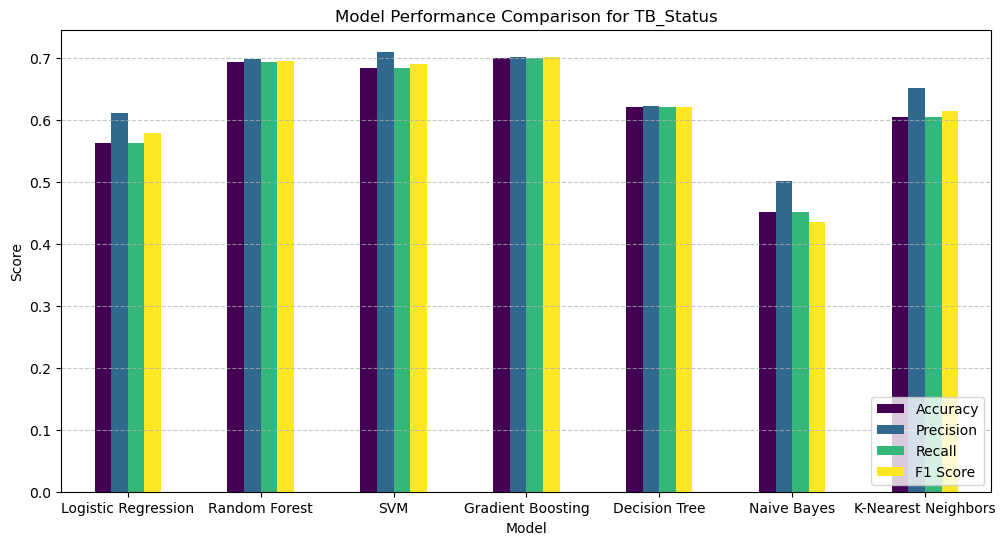

In [ ]:
# Example for encoding the labels (for TB_Status)
label_encoder = LabelEncoder()

# Fit and transform the training labels, and transform the test labels
y_train_TB_Status_balanced_encoded = label_encoder.fit_transform(y_train_TB_Status_balanced)
y_test_TB_Status_encoded = label_encoder.transform(y_test_TB_Status)

# Example for TB_Status
results_TB_Status, best_models_TB_Status = tune_and_evaluate(X_train_TB_Status_balanced, y_train_TB_Status_balanced_encoded,
                                                             X_test_TB_Status_selected, y_test_TB_Status_encoded)

# Print the best model and its best hyperparameters
for model_name, best_model in best_models_TB_Status.items():
    print(f"Best model for {model_name}: {best_model}")
    print(f"Best hyperparameters: {results_TB_Status[results_TB_Status['Model'] == model_name]['Best Hyperparameters'].values[0]}\n")

# Identify the overall best model based on a chosen metric (e.g., F1 Score)
best_model_overall = results_TB_Status.loc[results_TB_Status["F1 Score"].idxmax()]
print("\nOverall Best Model:")
print(f"Model: {best_model_overall['Model']}")
print(f"Accuracy: {best_model_overall['Accuracy']:.4f}")
print(f"Precision: {best_model_overall['Precision']:.4f}")
print(f"Recall: {best_model_overall['Recall']:.4f}")
print(f"F1 Score: {best_model_overall['F1 Score']:.4f}")
print(f"Best Hyperparameters: {best_model_overall['Best Hyperparameters']}")

# Visualize the results
def visualize_results(results_df, title):
    results_df.set_index("Model", inplace=True)
    results_df.drop(columns="Best Hyperparameters", inplace=True)  # Remove the hyperparameters column for visualization
    results_df.plot(kind='bar', figsize=(12, 6), rot=0, colormap='viridis')
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

visualize_results(results_TB_Status, "Model Performance Comparison for TB_Status")


## Training the model using best algorithm

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline for scaling and modeling with Gradient Boosting
model_TB_Status = make_pipeline(
    StandardScaler(),  # Scale the data
    GradientBoostingClassifier(random_state=42)  # Gradient Boosting Model
)

# Improve the model with an expanded hyperparameter search for GridSearchCV
param_grid = {
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
    'gradientboostingclassifier__n_estimators': [50, 100, 150, 200, 250],
    'gradientboostingclassifier__max_depth': [3, 4, 5, 6],
    'gradientboostingclassifier__subsample': [0.7, 0.8, 0.9, 1.0],  # Regularization technique
    'gradientboostingclassifier__min_samples_split': [2, 5, 10],  # Regularization technique
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 5]  # Regularization technique
}

# GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    model_TB_Status, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train_TB_Status_balanced, y_train_TB_Status_balanced)

# Display the best parameters
print("Best Parameters for TB_Status Model:", grid_search.best_params_)

# Best model from GridSearchCV
best_model_TB_Status = grid_search.best_estimator_

# Evaluate the best model
y_pred_best_TB_Status = best_model_TB_Status.predict(X_test_TB_Status_selected)
print("Best TB_Status Classification Report after GridSearchCV:")
print(classification_report(y_test_TB_Status, y_pred_best_TB_Status))


Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
Best Parameters for TB_Status Model: {'gradientboostingclassifier__learning_rate': 0.3, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__min_samples_split': 5, 'gradientboostingclassifier__n_estimators': 250, 'gradientboostingclassifier__subsample': 0.8}
Best TB_Status Classification Report after GridSearchCV:
                 precision    recall  f1-score   support

Healthy Control       0.74      0.68      0.71        47
  Other Disease       0.69      0.74      0.72       123
             TB       0.76      0.74      0.75       144

       accuracy                           0.73       314
      macro avg       0.73      0.72      0.72       314
   weighted avg       0.73      0.73      0.73       314



## Feature Selection for 'PTB_EPTB'

In [ ]:
# --- Feature Selection for 'PTB_EPTB' using Lasso ---
# Lasso for feature selection
selector_TB_Type = LassoCV(cv=5)  # LassoCV automatically selects the best alpha (regularization parameter)

# Encode the target variable (y_PTB_EPTB) to numeric values
label_encoder_PTB_EPTB = LabelEncoder()
y_PTB_EPTB_encoded = label_encoder_PTB_EPTB.fit_transform(y_PTB_EPTB)

# Fit the Lasso model
selector_TB_Type.fit(X_PTB_EPTB, y_PTB_EPTB_encoded)

# Get the absolute values of the coefficients
coefficients = abs(selector_TB_Type.coef_)

# Get the indices of the top 10 features based on the absolute value of the coefficients
top_10_indices = coefficients.argsort()[-10:][::-1]

# Select the corresponding feature names
selected_features_PTB_EPTB = X_PTB_EPTB.columns[top_10_indices]

# Save selected features to CSV
selected_features_df_PTB_EPTB = pd.DataFrame(selected_features_PTB_EPTB, columns=['Selected Features'])
selected_features_df_PTB_EPTB.to_csv(r'/content/drive/MyDrive/Research/finalDatasets/selected_features_PTB_EPTB.csv', index=False)

# Show the selected features
selected_features_df_PTB_EPTB


## Sub-Model 2: Predict TB_Type

In [ ]:
from sklearn.feature_selection import SelectFromModel

# --- Encode the target labels ---
label_encoder_TB_Type = LabelEncoder()
y_PTB_EPTB_encoded = label_encoder_TB_Type.fit_transform(y_PTB_EPTB)

# --- Split the dataset to features and target ---
X_train_TB_Type, X_test_TB_Type, y_train_TB_Type, y_test_TB_Type = train_test_split(
    X_PTB_EPTB, y_PTB_EPTB_encoded, test_size=0.2, random_state=42
)

# --- Feature Selection with LassoCV using SelectFromModel ---
selector_TB_Type = SelectFromModel(LassoCV(cv=5), threshold="mean")  # Select features based on coefficients
selector_TB_Type.fit(X_train_TB_Type, y_train_TB_Type)

# Transform the data for TB_Type
X_train_TB_Type_selected = selector_TB_Type.transform(X_train_TB_Type)
X_test_TB_Type_selected = selector_TB_Type.transform(X_test_TB_Type)

# --- Handle class imbalance ---
smote = SMOTE(random_state=42)
X_train_TB_Type_balanced, y_train_TB_Type_balanced = smote.fit_resample(X_train_TB_Type_selected, y_train_TB_Type)

# Fit the scaler to the training data
scaler_TB_Type = StandardScaler().fit(X_train_TB_Type_balanced)


In [ ]:
# Save the scaler
joblib.dump(scaler_TB_Type, '/content/drive/MyDrive/Research/TB_models/scaler_TB_Type.pkl')

['scaler_TB_Type.pkl']

## Comparison between the different algorithms

Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuning Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Tuning Decision Tree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuning Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best model for Logistic Regression: LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
Best hyperparameters: {'C': 0.1, 'solver': 'liblinear'}

Best model for Random Forest: RandomForestClassifier(min_samples_split=5, n_estimators=150)
Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}

Best model for SVM: SVC(C=1)
Best hyperparameters: {'C': 1, 'gamma

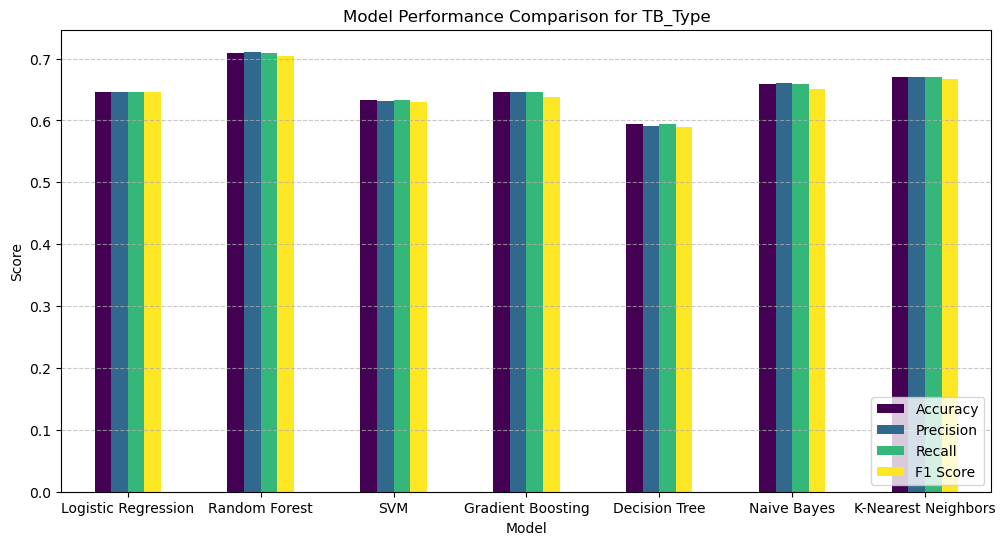

In [ ]:
# Example for encoding the labels (for TB_Type)
label_encoder = LabelEncoder()

# Fit and transform the training labels, and transform the test labels
y_train_TB_Type_balanced_encoded = label_encoder.fit_transform(y_train_TB_Type_balanced)
y_test_TB_Type_encoded = label_encoder.transform(y_test_TB_Type)

# Example for TB_Type
results_TB_Type, best_models_TB_Type = tune_and_evaluate(X_train_TB_Type_balanced, y_train_TB_Type_balanced_encoded,
                                                             X_test_TB_Type_selected, y_test_TB_Type_encoded)

# Print the best model and its best hyperparameters
for model_name, best_model in best_models_TB_Type.items():
    print(f"Best model for {model_name}: {best_model}")
    print(f"Best hyperparameters: {results_TB_Type[results_TB_Type['Model'] == model_name]['Best Hyperparameters'].values[0]}\n")

# Identify the overall best model based on a chosen metric (e.g., F1 Score)
best_model_overall = results_TB_Type.loc[results_TB_Type["F1 Score"].idxmax()]
print("\nOverall Best Model:")
print(f"Model: {best_model_overall['Model']}")
print(f"Accuracy: {best_model_overall['Accuracy']:.4f}")
print(f"Precision: {best_model_overall['Precision']:.4f}")
print(f"Recall: {best_model_overall['Recall']:.4f}")
print(f"F1 Score: {best_model_overall['F1 Score']:.4f}")
print(f"Best Hyperparameters: {best_model_overall['Best Hyperparameters']}")

# Visualize the results
def visualize_results(results_df, title):
    results_df.set_index("Model", inplace=True)
    results_df.drop(columns="Best Hyperparameters", inplace=True)  # Remove the hyperparameters column for visualization
    results_df.plot(kind='bar', figsize=(12, 6), rot=0, colormap='viridis')
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

visualize_results(results_TB_Type, "Model Performance Comparison for TB_Type")


## Training the model using best algorithm

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # For class balancing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# Define TB type label names
tb_type_labels = ["Pulmonary TB", "Extra Pulmonary TB"]

# Step 1: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_TB_Type_balanced, y_train_TB_Type_balanced)

# Step 2: Feature selection using Extra Trees Classifier
feature_selector = SelectFromModel(ExtraTreesClassifier(random_state=42), threshold="mean")
X_train_selected = feature_selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = feature_selector.transform(X_test_TB_Type_selected)

# Step 3: Define the pipeline for scaling and Random Forest classifier
model_TB_Type = make_pipeline(
    StandardScaler(),  # Ensure scaling if input features require it
    RandomForestClassifier(
        random_state=42,
        oob_score=True,  # Use Out-of-Bag samples to monitor generalization error
        warm_start=True  # Allow incremental training
    )
)

# Step 4: Expanded parameter grid for GridSearchCV
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],  # Limit to smaller ranges for speed improvement
    'randomforestclassifier__max_depth': [10, 20, 30],  # Depth control to prevent overfitting
    'randomforestclassifier__min_samples_split': [2, 5, 10],  # Minimal splits
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],  # Control leaf size
    'randomforestclassifier__max_features': ['sqrt', 'log2'],  # Limit to important features
    'randomforestclassifier__bootstrap': [True]  # Allow both types of bootstrapping
}

# Step 5: Use Stratified KFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_TB_Type, param_grid, cv=stratified_cv, scoring='accuracy', n_jobs=-1, verbose=1
)

# Step 6: Fit the grid search to the training data
grid_search.fit(X_train_selected, y_train_balanced)

# Step 7: Display the best parameters
print("Best Parameters for TB_Type Model:", grid_search.best_params_)

# Step 8: Best model from GridSearchCV
best_model_TB_Type = grid_search.best_estimator_

# Step 9: Evaluate the best model
y_pred_best_TB_Type = best_model_TB_Type.predict(X_test_selected)

# Step 10: Print classification report with label names
print("Best TB_Type Classification Report after GridSearchCV:")
print(classification_report(y_test_TB_Type, y_pred_best_TB_Type, target_names=tb_type_labels))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters for TB_Type Model: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Best TB_Type Classification Report after GridSearchCV:
                    precision    recall  f1-score   support

      Pulmonary TB       0.69      0.81      0.74        43
Extra Pulmonary TB       0.71      0.56      0.63        36

          accuracy                           0.70        79
         macro avg       0.70      0.68      0.68        79
      weighted avg       0.70      0.70      0.69        79



## Feature Selection for 'ATB_LTB'

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
import pandas as pd

# --- Encode categorical target variable y_ATB_LTB using LabelEncoder ---
label_encoder = LabelEncoder()
y_ATB_LTB_encoded = label_encoder.fit_transform(y_ATB_LTB)

# --- Feature Selection for ATB_LTB using Lasso ---
# Fit the Lasso model with cross-validation to determine the optimal alpha
lasso = LassoCV(cv=5)
lasso.fit(X_ATB_LTB, y_ATB_LTB_encoded)

# Get the absolute values of coefficients
coefficients = abs(lasso.coef_)

# Get the indices of the features selected by Lasso (non-zero coefficients)
selected_indices = [i for i in range(len(lasso.coef_)) if lasso.coef_[i] != 0]

# Get feature names and their corresponding coefficients
selected_features_and_coefficients = [
    (X_ATB_LTB.columns[i], coefficients[i]) for i in selected_indices
]

# Filter out 'ILMN_1821270' and sort by the coefficient magnitude in descending order
filtered_features = [
    feature for feature in selected_features_and_coefficients if feature[0] != 'ILMN_1821270'
]
filtered_features_sorted = sorted(filtered_features, key=lambda x: x[1], reverse=True)

# Select the top 10 features
top_10_features = [feature[0] for feature in filtered_features_sorted[:10]]

# Save selected features to CSV
selected_features_df_ATB_LTB = pd.DataFrame(top_10_features, columns=['Selected Features'])
selected_features_df_ATB_LTB.to_csv(r'/content/drive/MyDrive/Research/finalDatasets/selected_features_ATB_LTB.csv', index=False)

# Show the selected features
selected_features_df_ATB_LTB


,Selected Features
0,ILMN_1780368
1,ILMN_2315569
2,ILMN_2147105
3,ILMN_1712719
4,ILMN_1774077
5,ILMN_2413537
6,ILMN_1792799
7,ILMN_1680388
8,ILMN_2167426
9,ILMN_1769550


## Sub-Model 3: Predict TB_Stage

In [ ]:
from sklearn.feature_selection import SelectFromModel

# --- Encode the target labels ---
label_encoder_TB_Stage = LabelEncoder()
y_ATB_LTB_encoded = label_encoder_TB_Stage.fit_transform(y_ATB_LTB)

# --- Split the dataset to features and target ---
X_train_TB_Stage, X_test_TB_Stage, y_train_TB_Stage, y_test_TB_Stage = train_test_split(
    X_ATB_LTB, y_ATB_LTB_encoded, test_size=0.2, random_state=42
)

# --- Feature Selection with LassoCV using SelectFromModel ---
selector_TB_Stage = SelectFromModel(LassoCV(cv=5), threshold="mean")  # Select features based on coefficients
selector_TB_Stage.fit(X_train_TB_Stage, y_train_TB_Stage)

# Transform the data for TB_Stage
X_train_TB_Stage_selected = selector_TB_Stage.transform(X_train_TB_Stage)
X_test_TB_Stage_selected = selector_TB_Stage.transform(X_test_TB_Stage)

# --- Handle class imbalance ---
smote = SMOTE(random_state=42)
X_train_TB_Stage_balanced, y_train_TB_Stage_balanced = smote.fit_resample(X_train_TB_Stage_selected, y_train_TB_Stage)

# Fit the scaler to the training data
scaler_TB_Stage = StandardScaler().fit(X_train_TB_Stage_balanced)


In [ ]:
# Save the scaler
joblib.dump(scaler_TB_Stage, '/content/drive/MyDrive/Research/TB_models/scaler_TB_Stage.pkl')

['scaler_TB_Stage.pkl']

## Comparison between the different algorithms

Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuning Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Tuning Decision Tree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuning Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best model for Logistic Regression: LogisticRegression(C=100, max_iter=1000)
Best hyperparameters: {'C': 100, 'solver': 'lbfgs'}

Best model for Random Forest: RandomForestClassifier(max_depth=30, n_estimators=50)
Best hyperparameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}

Best model for SVM: SVC(C=1, kernel='linear')
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kerne

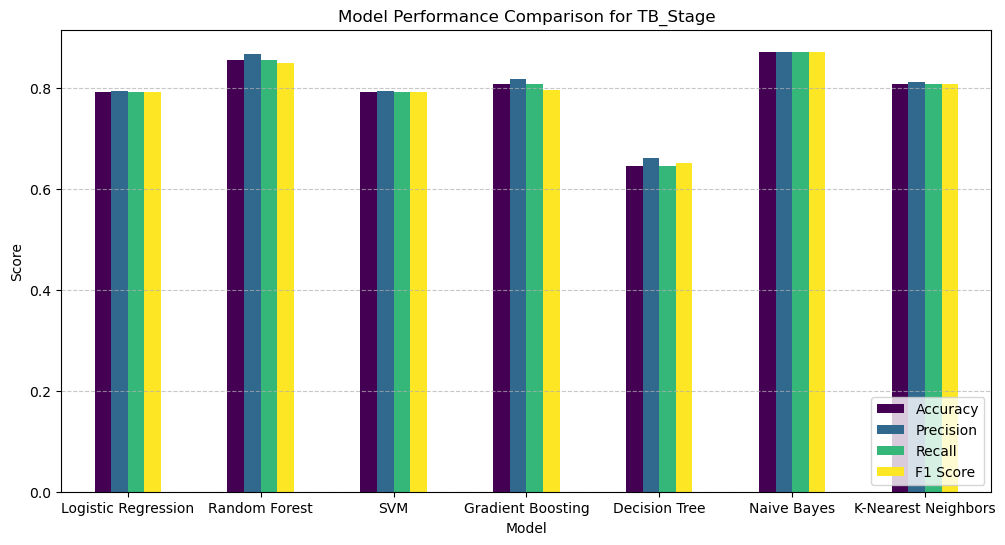

In [ ]:
# Example for encoding the labels (for TB_Stage)
label_encoder = LabelEncoder()

# Fit and transform the training labels, and transform the test labels
y_train_TB_Stage_balanced_encoded = label_encoder.fit_transform(y_train_TB_Stage_balanced)
y_test_TB_Stage_encoded = label_encoder.transform(y_test_TB_Stage)

# Example for TB_Stage
results_TB_Stage, best_models_TB_Stage = tune_and_evaluate(X_train_TB_Stage_balanced, y_train_TB_Stage_balanced_encoded,
                                                             X_test_TB_Stage_selected, y_test_TB_Stage_encoded)

# Print the best model and its best hyperparameters
for model_name, best_model in best_models_TB_Stage.items():
    print(f"Best model for {model_name}: {best_model}")
    print(f"Best hyperparameters: {results_TB_Stage[results_TB_Stage['Model'] == model_name]['Best Hyperparameters'].values[0]}\n")

# Identify the overall best model based on a chosen metric (e.g., F1 Score)
best_model_overall = results_TB_Stage.loc[results_TB_Stage["F1 Score"].idxmax()]
print("\nOverall Best Model:")
print(f"Model: {best_model_overall['Model']}")
print(f"Accuracy: {best_model_overall['Accuracy']:.4f}")
print(f"Precision: {best_model_overall['Precision']:.4f}")
print(f"Recall: {best_model_overall['Recall']:.4f}")
print(f"F1 Score: {best_model_overall['F1 Score']:.4f}")
print(f"Best Hyperparameters: {best_model_overall['Best Hyperparameters']}")

# Visualize the results
def visualize_results(results_df, title):
    results_df.set_index("Model", inplace=True)
    results_df.drop(columns="Best Hyperparameters", inplace=True)  # Remove the hyperparameters column for visualization
    results_df.plot(kind='bar', figsize=(12, 6), rot=0, colormap='viridis')
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

visualize_results(results_TB_Stage, "Model Performance Comparison for TB_Stage")


## Training the model using best algorithm

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define TB stage label names
tb_stage_labels = ["Active TB", "Latent TB"]

# Pipeline for scaling and modeling with Naive Bayes
model_TB_Stage = make_pipeline(
    StandardScaler(),  # Scaling the data for better GaussianNB performance
    GaussianNB()  # Naive Bayes Classifier
)

# Define a parameter grid for GridSearchCV
param_grid = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Smoothing parameter for GaussianNB
}

# GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    model_TB_Stage, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train_TB_Stage_balanced, y_train_TB_Stage_balanced)

# Display the best parameters
print("Best Parameters for TB_Stage Model:", grid_search.best_params_)

# Best model from GridSearchCV
best_model_TB_Stage = grid_search.best_estimator_

# Evaluate the best model
y_pred_best_TB_Stage = best_model_TB_Stage.predict(X_test_TB_Stage_selected)

# Print classification report with label names
print("Best TB_Stage Classification Report after GridSearchCV:")
print(classification_report(y_test_TB_Stage, y_pred_best_TB_Stage, target_names=tb_stage_labels))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for TB_Stage Model: {'gaussiannb__var_smoothing': 1e-09}
Best TB_Stage Classification Report after GridSearchCV:
              precision    recall  f1-score   support

   Active TB       0.86      0.78      0.82        23
   Latent TB       0.88      0.92      0.90        39

    accuracy                           0.87        62
   macro avg       0.87      0.85      0.86        62
weighted avg       0.87      0.87      0.87        62



## Evaluation of the sub models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and display metrics
def evaluate_model(y_true, y_pred, label):
    print(f"\n--- Evaluation Metrics for {label} ---")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


--- Model Evaluation ---

--- Evaluation Metrics for TB_Status ---
Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73




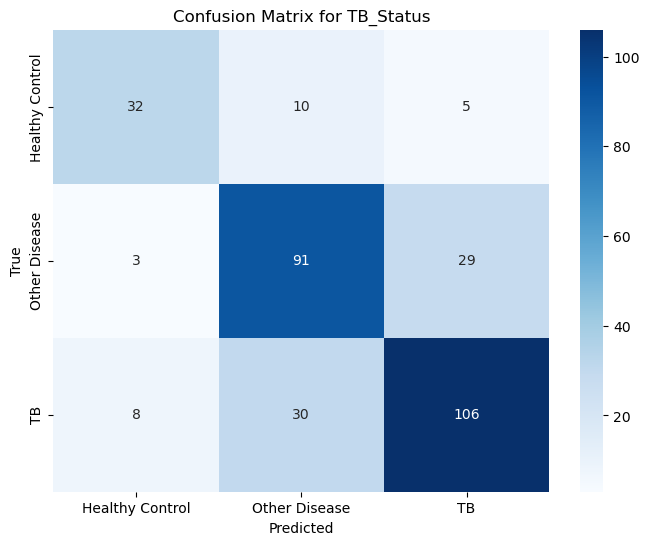

In [ ]:
# Evaluate models using test datasets
print("\n--- Model Evaluation ---")
# TB_Status Evaluation using the best model
y_pred_TB_Status = best_model_TB_Status.predict(X_test_TB_Status_selected)
evaluate_model(y_test_TB_Status, y_pred_TB_Status, "TB_Status")



--- Model Evaluation ---

--- Evaluation Metrics for TB_Type ---
Accuracy: 0.70
Precision: 0.70
Recall: 0.70
F1 Score: 0.69




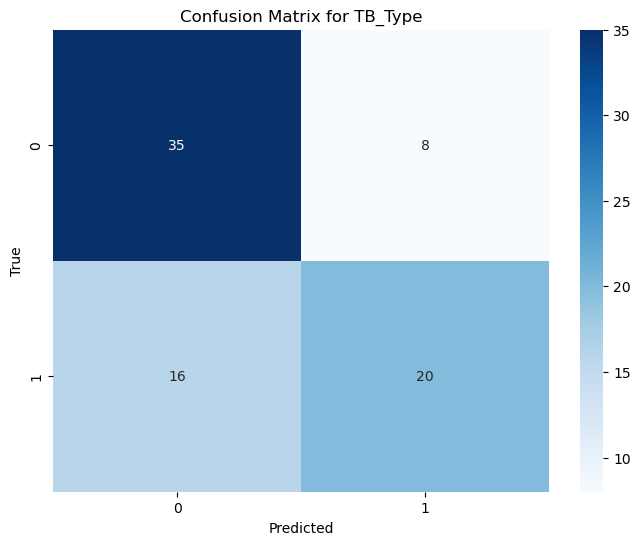

In [ ]:
# Evaluate models using test datasets
print("\n--- Model Evaluation ---")
# TB_Type Evaluation
y_pred_TB_Type = best_model_TB_Type.predict(X_test_selected)
evaluate_model(y_test_TB_Type, y_pred_TB_Type, "TB_Type")


--- Model Evaluation ---

--- Evaluation Metrics for TB_Stage ---
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1 Score: 0.87




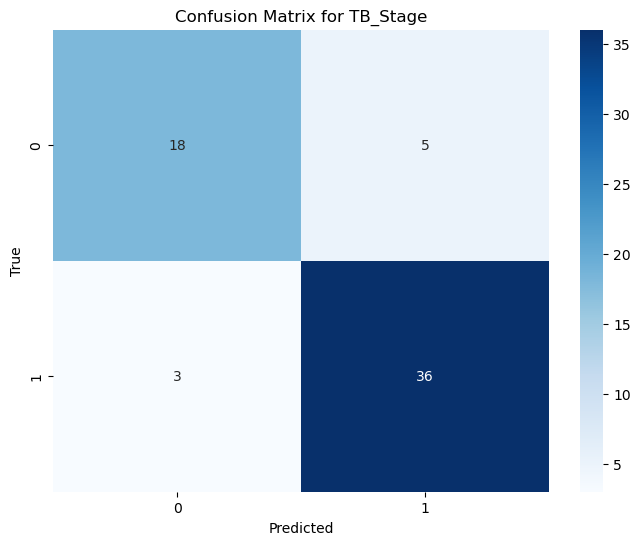

In [ ]:
# Evaluate models using test datasets
print("\n--- Model Evaluation ---")
# TB_Stage Evaluation
y_pred_TB_Stage = best_model_TB_Stage.predict(X_test_TB_Stage_selected)
evaluate_model(y_test_TB_Stage, y_pred_TB_Stage, "TB_Stage")

In [ ]:
import joblib

# Save trained models
joblib.dump(best_model_TB_Status, r'/content/drive/MyDrive/Research/TB_models/best_model_TB_Status.pkl')
joblib.dump(best_model_TB_Type, r'/content/drive/MyDrive/Research/TB_models/best_model_TB_Type.pkl')
joblib.dump(best_model_TB_Stage, r'/content/drive/MyDrive/Research/TB_models/best_model_TB_Stage.pkl')

print("Saved successfully.")


Saved successfully.


In [ ]:
# Load models
best_model_TB_Status = joblib.load(r'/content/drive/MyDrive/Research/TB_models/best_model_TB_Status.pkl')
best_model_TB_Type = joblib.load(r'/content/drive/MyDrive/Research/TB_models/best_model_TB_Type.pkl')
best_model_TB_Stage = joblib.load(r'/content/drive/MyDrive/Research/TB_models/best_model_TB_Stage.pkl')


## Overall Prediction

In [ ]:
# --- Overall Prediction Function ---
def overall_prediction(input_features):
    # Transform the input for TB_Status
    input_features_TB_Status = selector_TB_Status.transform(input_features)
    TB_Status_pred = model_TB_Status.predict(input_features_TB_Status)

    # If TB_Status is predicted as "TB," proceed to further predictions
    if TB_Status_pred[0] == 'TB':
        # Transform the input for TB_Type
        input_features_TB_Type = selector_TB_Type.transform(input_features)
        TB_Type_pred = model_TB_Type.predict(input_features_TB_Type)

        # Decode TB_Type prediction
        if TB_Type_pred[0] == 0:
            TB_Type_pred_label = 'Pulmonary TB'
        elif TB_Type_pred[0] == 1:
            TB_Type_pred_label = 'Extra Pulmonary TB'
        else:
            TB_Type_pred_label = 'Unknown'  # Fallback case

        # If TB_Type is "Pulmonary TB" or "Extra Pulmonary TB," proceed to predict TB_Stage
        if TB_Type_pred_label in ['Pulmonary TB', 'Extra Pulmonary TB']:
            # Transform the input for TB_Stage
            input_features_TB_Stage = selector_TB_Stage.transform(input_features)
            TB_Stage_pred = model_TB_Stage.predict(input_features_TB_Stage)

            # Decode TB_Stage prediction
            if TB_Stage_pred[0] == 0:
                TB_Stage_pred_label = 'Active TB'
            elif TB_Stage_pred[0] == 1:
                TB_Stage_pred_label = 'Latent TB'
            else:
                TB_Stage_pred_label = 'Unknown'  # Fallback case

            return TB_Status_pred[0], TB_Type_pred_label, TB_Stage_pred_label
        else:
            return TB_Status_pred[0], TB_Type_pred_label, None
    else:
        return TB_Status_pred[0], None, None


## Predictions

In [ ]:
# --- Model predictions ---
# Row index
n = 9

# Prepare the test input with scaling for each stage
test_input = pd.DataFrame([X_test_TB_Status.iloc[n, :].values], columns=X_test_TB_Status.columns)

# Ensure all scalers and selectors are fitted before using them
scaler_TB_Status.fit(X_train_TB_Status_selected)
scaler_TB_Type.fit(X_train_TB_Type_selected)
scaler_TB_Stage.fit(X_train_TB_Stage_selected)

# Fit pipelines (if not already fitted during model training)
model_TB_Status.fit(X_train_TB_Status_selected, y_train_TB_Status)
model_TB_Type.fit(X_train_TB_Type_selected, y_train_TB_Type)
model_TB_Stage.fit(X_train_TB_Stage_selected, y_train_TB_Stage)

# Run overall prediction
predicted_TB_Status, predicted_TB_Type, predicted_TB_Stage = overall_prediction(test_input)

# Display predictions
print("Predicted TB_Status:", predicted_TB_Status)
if predicted_TB_Status == 'TB':
    print("Predicted TB_Type:", predicted_TB_Type)
    if predicted_TB_Type in ['Pulmonary TB', 'Extra Pulmonary TB']:
        print("Predicted TB_Stage:", predicted_TB_Stage)
    else:
        print("TB_Type prediction does not require TB_Stage prediction.")
else:
    print("No further predictions required as TB_Status is not 'TB'.")

# Display true TB_Status label
true_TB_Status = y_test_TB_Status.iloc[n]  # Access the true label for TB_Status using .iloc
print("\nTrue TB_Status Label:")
print(true_TB_Status)


C:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Predicted TB_Status: TB
Predicted TB_Type: Pulmonary TB
Predicted TB_Stage: Active TB

True TB_Status Label:
TB


In [ ]:
# --- Model predictions ---
# Row index
n = 8

# Prepare the test input with scaling for each stage
test_input = pd.DataFrame([X_test_TB_Status.iloc[n, :].values], columns=X_test_TB_Status.columns)

# Ensure all scalers and selectors are fitted before using them
scaler_TB_Status.fit(X_train_TB_Status_selected)
scaler_TB_Type.fit(X_train_TB_Type_selected)
scaler_TB_Stage.fit(X_train_TB_Stage_selected)

# Fit pipelines (if not already fitted during model training)
model_TB_Status.fit(X_train_TB_Status_selected, y_train_TB_Status)
model_TB_Type.fit(X_train_TB_Type_selected, y_train_TB_Type)
model_TB_Stage.fit(X_train_TB_Stage_selected, y_train_TB_Stage)

# Run overall prediction
predicted_TB_Status, predicted_TB_Type, predicted_TB_Stage = overall_prediction(test_input)

# Display predictions
print("Predicted TB_Status:", predicted_TB_Status)
if predicted_TB_Status == 'TB':
    print("Predicted TB_Type:", predicted_TB_Type)
    if predicted_TB_Type in ['Pulmonary TB', 'Extra Pulmonary TB']:
        print("Predicted TB_Stage:", predicted_TB_Stage)
    else:
        print("TB_Type prediction does not require TB_Stage prediction.")
else:
    print("No further predictions required as TB_Status is not 'TB'.")

# Display true TB_Status label
true_TB_Status = y_test_TB_Status.iloc[n]  # Access the true label for TB_Status using .iloc
print("\nTrue TB_Status Label:")
print(true_TB_Status)


Predicted TB_Status: Other Disease
No further predictions required as TB_Status is not 'TB'.

True TB_Status Label:
TB


C:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


In [ ]:
# --- Model predictions ---
# Row index
n = 11

# Prepare the test input with scaling for each stage
test_input = pd.DataFrame([X_test_TB_Status.iloc[n, :].values], columns=X_test_TB_Status.columns)

# Ensure all scalers and selectors are fitted before using them
scaler_TB_Status.fit(X_train_TB_Status_selected)
scaler_TB_Type.fit(X_train_TB_Type_selected)
scaler_TB_Stage.fit(X_train_TB_Stage_selected)

# Fit pipelines (if not already fitted during model training)
model_TB_Status.fit(X_train_TB_Status_selected, y_train_TB_Status)
model_TB_Type.fit(X_train_TB_Type_selected, y_train_TB_Type)
model_TB_Stage.fit(X_train_TB_Stage_selected, y_train_TB_Stage)

# Run overall prediction
predicted_TB_Status, predicted_TB_Type, predicted_TB_Stage = overall_prediction(test_input)

# Display predictions
print("Predicted TB_Status:", predicted_TB_Status)
if predicted_TB_Status == 'TB':
    print("Predicted TB_Type:", predicted_TB_Type)
    if predicted_TB_Type in ['Pulmonary TB', 'Extra Pulmonary TB']:
        print("Predicted TB_Stage:", predicted_TB_Stage)
    else:
        print("TB_Type prediction does not require TB_Stage prediction.")
else:
    print("No further predictions required as TB_Status is not 'TB'.")

# Display true TB_Status label
true_TB_Status = y_test_TB_Status.iloc[n]  # Access the true label for TB_Status using .iloc
print("\nTrue TB_Status Label:")
print(true_TB_Status)


Predicted TB_Status: Healthy Control
No further predictions required as TB_Status is not 'TB'.

True TB_Status Label:
Healthy Control


C:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
